In [1]:
# Gain modulation RNN with oja learning on weight matrix, nonlinear lqg, ongoing oja
import numpy as np
from numpy.random import multivariate_normal as mvnrnd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from rnn_gn import RNN
import json
from torch.autograd.functional import jacobian
from torch import tensor
import torch
import torch.nn as nn
import scipy.linalg as sp_linalg
from tqdm import tqdm

## Loading Trained Weights

In [2]:
with open('../weights/sinwave_wt_128_nodes/weight_history.json') as f:
    weight_history = json.load(f)

In [3]:
weight_history.keys()

dict_keys(['trained gain', 'trained shift', 'trained weights', 'connectivity matrix', 'input weights', 'output weights', 'losses', 'init_weight'])

In [4]:
gains = np.array(weight_history['trained gain'])
shifts = np.array(weight_history['trained shift'])
weight_matrix = np.array(weight_history['trained weights'])
connectivity_matrix = np.array(weight_history['connectivity matrix'])
input_weight_matrix = np.array(weight_history['input weights'])
output_weight_matrix = np.array(weight_history['output weights'])
losses = np.array(weight_history['losses'])
# gain_changes = np.array(weight_history['gain_changes'])
# shift_changes = np.array(weight_history['shift_changes'])
init_weight_matrix = np.array(weight_history['init_weight'])
# weights = weight_history['weights']

## Defining Network

In [5]:
time_constant = 100 #ms
timestep = 10 #ms
time = 20000 #ms
T_max = time // timestep
num_inputs = 1
num_nodes = 128
init_activations = np.zeros((num_nodes, 1))

network = RNN(weight_matrix, connectivity_matrix, init_activations, gains, shifts, input_weight_matrix, output_weight_matrix, 
                time_constant = time_constant, timestep = timestep)

# define inputs and targets
dt = network.timestep/network.time_const
T = np.arange(0, T_max)

time_points = np.arange(T_max).reshape(-1, 1)
inputs = np.sin(time_points/60*np.pi)
targets = np.sin((time_points+1)/60*np.pi)
inputs = inputs.reshape(-1, 1)
targets = targets.reshape(-1, 1)

In [6]:
# from model
outputs, activations = network.simulate(time, torch.tensor(inputs).float()) 

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:00<00:00, 28402.26it/s]


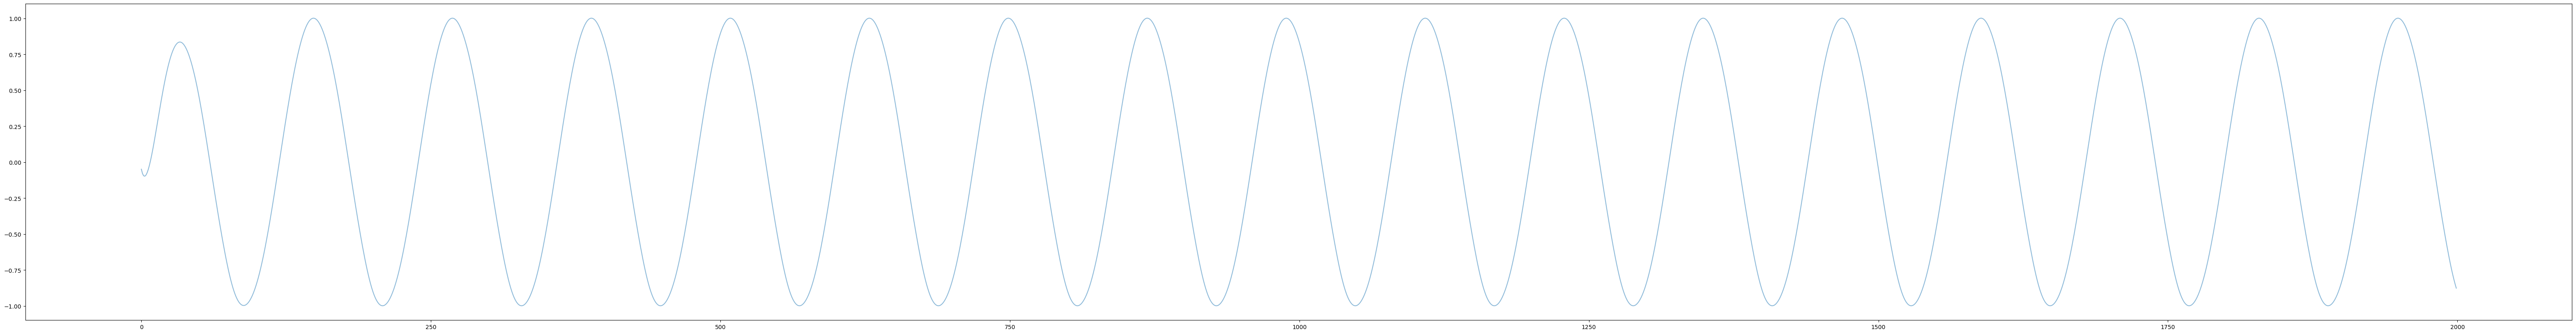

In [7]:
plt.subplots(figsize=(80,10))
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='simu')

## Manual Simulatation

In [50]:
class myrnn():
    def __init__(self, weights, gains, shifts, inputs, input_weights, connectivity_matrix):
        # core parameters
        self.weights = weights
        self.gains = gains
        self.shifts = shifts
        self.inputs = inputs
        self.input_weights = input_weights
        self.activation_func = nn.Sigmoid()

        # transfer into tensor
        self.weights_tensor = tensor(self.weights)
        self.gains_tensor = tensor(self.gains)
        self.shifts_tensor = tensor(self.shifts)
        
        # weight type
        self.weight_type = self.weights >= 0
        self.connectivity_matrix = connectivity_matrix

        # time step
        self.i = 0

    def f_tensor(self, x_tensor, u_tensor):
        this_input = self.inputs[self.i] * self.input_weights.T
        this_input_tensor = tensor(this_input)
        y_tensor = (1 - dt) * x_tensor + dt * self.activation_func((self.gains_tensor + u_tensor) * (torch.matmul(self.weights_tensor, x_tensor) + this_input_tensor - self.shifts_tensor))
        return y_tensor
     
    def f(self, x, u):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        y_tensor = self.f_tensor(x_tensor, u_tensor)
        y = y_tensor.numpy()
        return y
    
    def jacob(self, x, u):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        dydx, dydu = jacobian(self.f_tensor,(x_tensor, u_tensor))
        Jx_tensor = dydx.squeeze(dim=(1,3))
        Ju_tensor = dydu.squeeze(dim=(1,3))
        Jx = Jx_tensor.numpy()
        Ju = Ju_tensor.numpy()
        return Jx, Ju

jnn_ff = myrnn(weight_matrix, gains, shifts, inputs, input_weight_matrix, connectivity_matrix)
jnn_fb = myrnn(weight_matrix, gains, shifts, inputs, input_weight_matrix, connectivity_matrix)
jnn = myrnn(weight_matrix, gains, shifts, inputs, input_weight_matrix, connectivity_matrix)

In [81]:
# define matrices
c = np.eye(num_nodes)
Bnoise = np.eye(num_nodes)
W = np.eye(num_nodes) * 0.001
V = np.eye(num_nodes) * 0.001
Q = np.eye(num_nodes) * 1
R = np.eye(num_nodes) * 0.01

# define noise
np.random.seed(42)
x_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=W, size=len(T))).T * 0
y_noises = (np.random.multivariate_normal(mean=np.zeros(num_nodes), cov=V, size=len(T))).T * 0
x_noises[:,500:1500] += 0.1

In [82]:
# Simulation Without Control
x = init_activations.copy()
u = init_activations.copy()
xs = []
ys = []
outputs_o = []

oja_alpha = np.sqrt(num_nodes)
hebbian_lr = 0.001
weightss = []

for i in tqdm(T):
    
    jnn_ff.i = i

    # update x
    process_noise = x_noises[:,i].reshape(-1,1)
    x1 = jnn_ff.f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # output
    y = c @ x
    output = output_weight_matrix @ x
    
    # save
    xs.append(x)
    ys.append(y)
    outputs_o.append(output.item())

100%|██████████| 2000/2000 [00:00<00:00, 4872.87it/s]


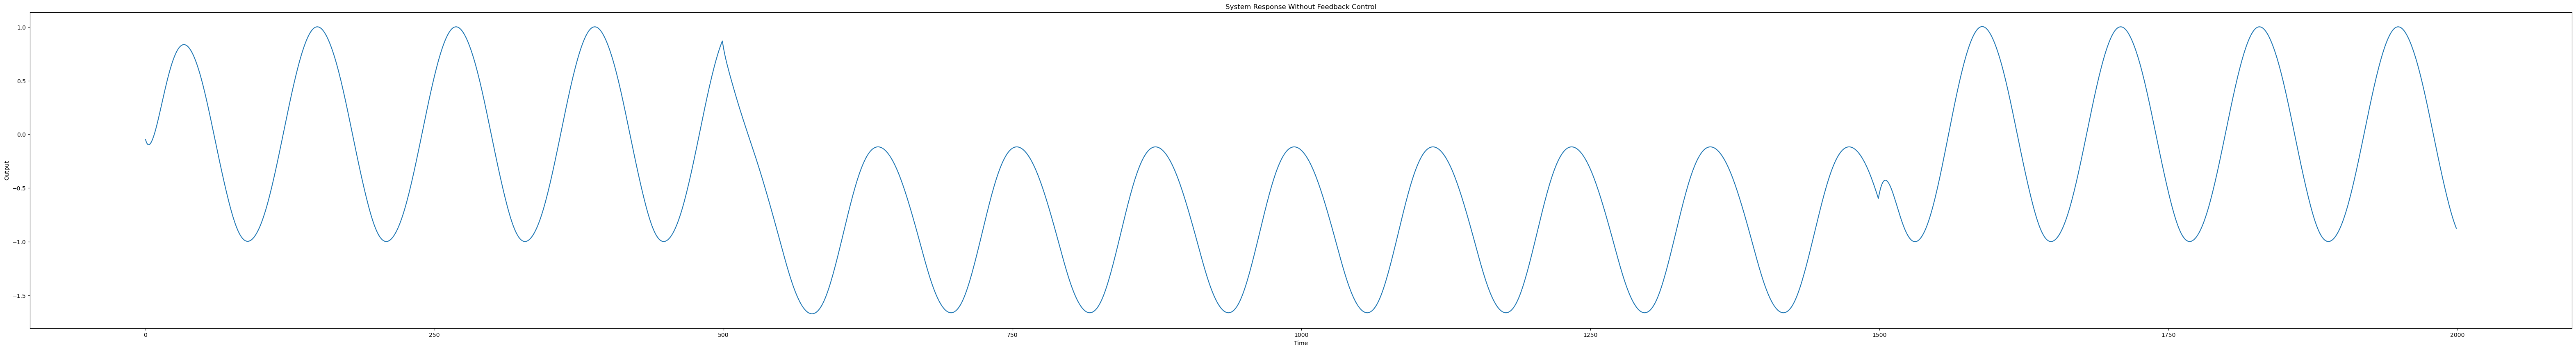

In [83]:
# Plot the output
plt.subplots(figsize=(80,10))
plt.plot(T, outputs_o)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

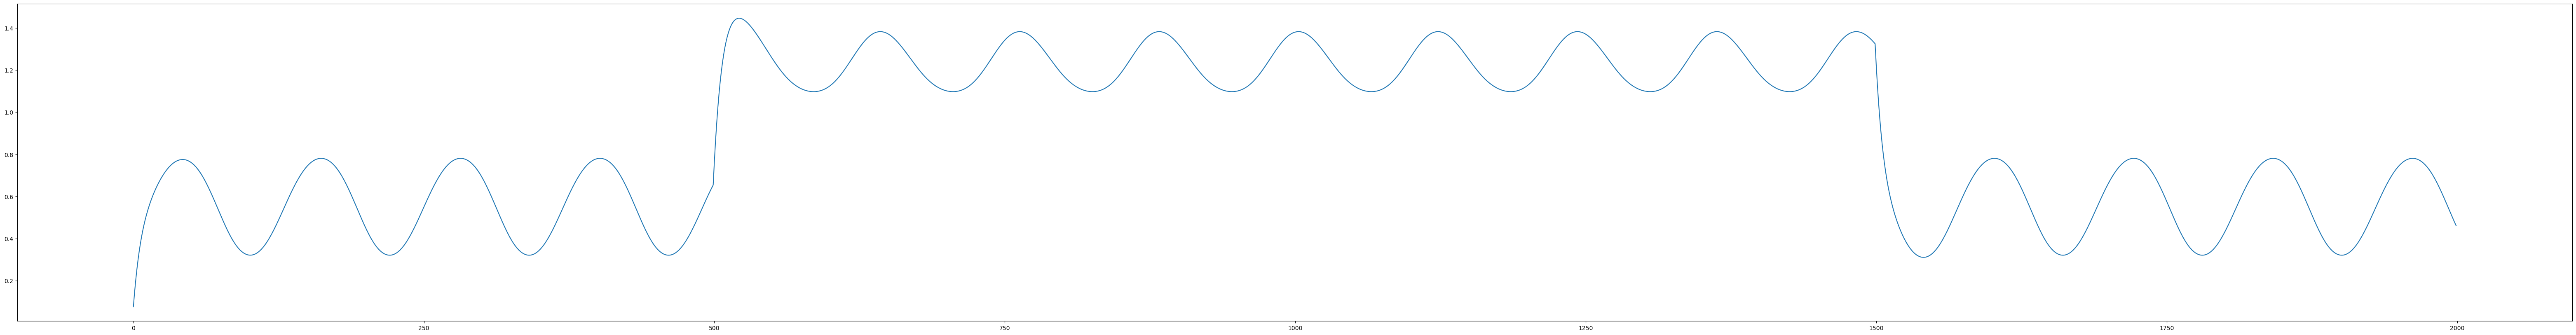

In [84]:
plt.subplots(figsize=(80,10))
x1s = [x[0].item() for x in xs]
plt.plot(T, x1s)
plt.show()

## Non-linear LQG

In [85]:
ideal_activations = activations.detach().numpy()
x = init_activations.copy()
u = init_activations.copy()
xhat = init_activations.copy()
Phat = W.copy()
xs = []
ys = []
ctrlus = []
xhats = []
outputs_b = []
op_afterlqrs = []

for i in tqdm(T):

    jnn_fb.i = i

    # to show the effect of lqr
    x_afterlqr = jnn_fb.f(x, u)
    op_afterlqr = output_weight_matrix @ x_afterlqr
    op_afterlqrs.append(op_afterlqr.item())

    # Update x
    process_noise = x_noises[:,i].reshape(-1,1)
    x1 = jnn_fb.f(x, u) + Bnoise @ process_noise
    x = x1.copy()

    # Output
    measurement_noise = y_noises[:,i].reshape(-1,1)
    y = c @ x + measurement_noise
    output = output_weight_matrix @ x

    # Save
    xs.append(x)
    ys.append(y)
    outputs_b.append(output.item())

    # Kalman
    # xpred = jnn_fb.f(xhat, u)
    # F, _ = jnn_fb.jacob(xhat, u)
    # Ppred = F @ Phat @ F.T + W
    # ypred = c @ xpred

    # S = c @ Ppred @ c.T + V
    # Kf = Ppred @ c.T @ np.linalg.inv(S)

    # xhat = xpred + Kf @ (y - ypred)
    # phat = Ppred - Kf @ c @ Ppred
    # yres = y - c @ xhat

    xhat = x.copy()
    xhats.append(xhat)

    # LQR
    this_ideal_activation = ideal_activations[i,:].reshape(-1,1)
    A, B = jnn_fb.jacob(x, u)
    X = sp_linalg.solve_discrete_are(A, B, Q, R)
    K = np.dot(np.linalg.pinv(R + np.dot(B.T, np.dot(X, B))), np.dot(B.T, np.dot(X, A)))
    u = -K @ (xhat - this_ideal_activation)
    if np.sum(np.abs(u)) > 1000:
        u = u / np.sum(np.abs(u)) * 1000
    ctrlus.append(u)
    # print(np.mean(u))

100%|██████████| 2000/2000 [07:08<00:00,  4.67it/s]


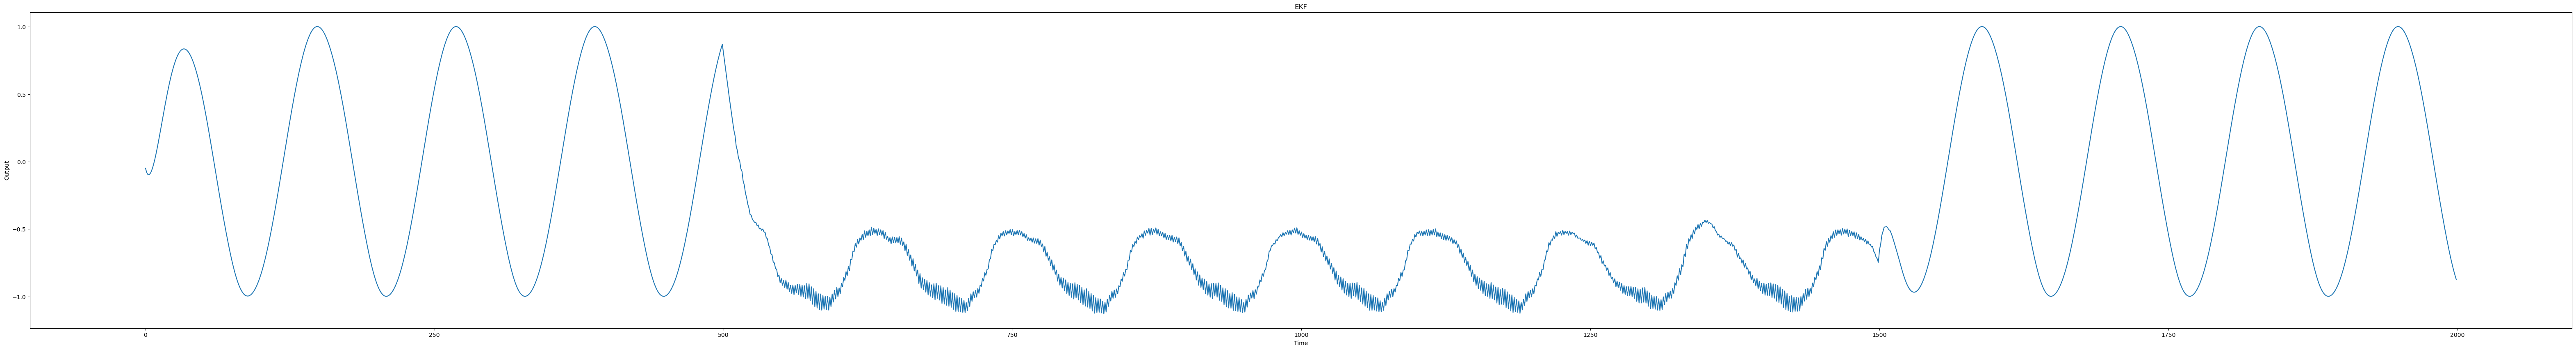

In [90]:
# Plot the state
plt.subplots(figsize=(80,10))
# outputhats = [(output_weight_matrix @ x).item() for x in xhats]
plt.plot(T, outputs_b)
# plt.plot(T, outputs_o)
# plt.plot(T, outputhats)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('EKF')
plt.show()

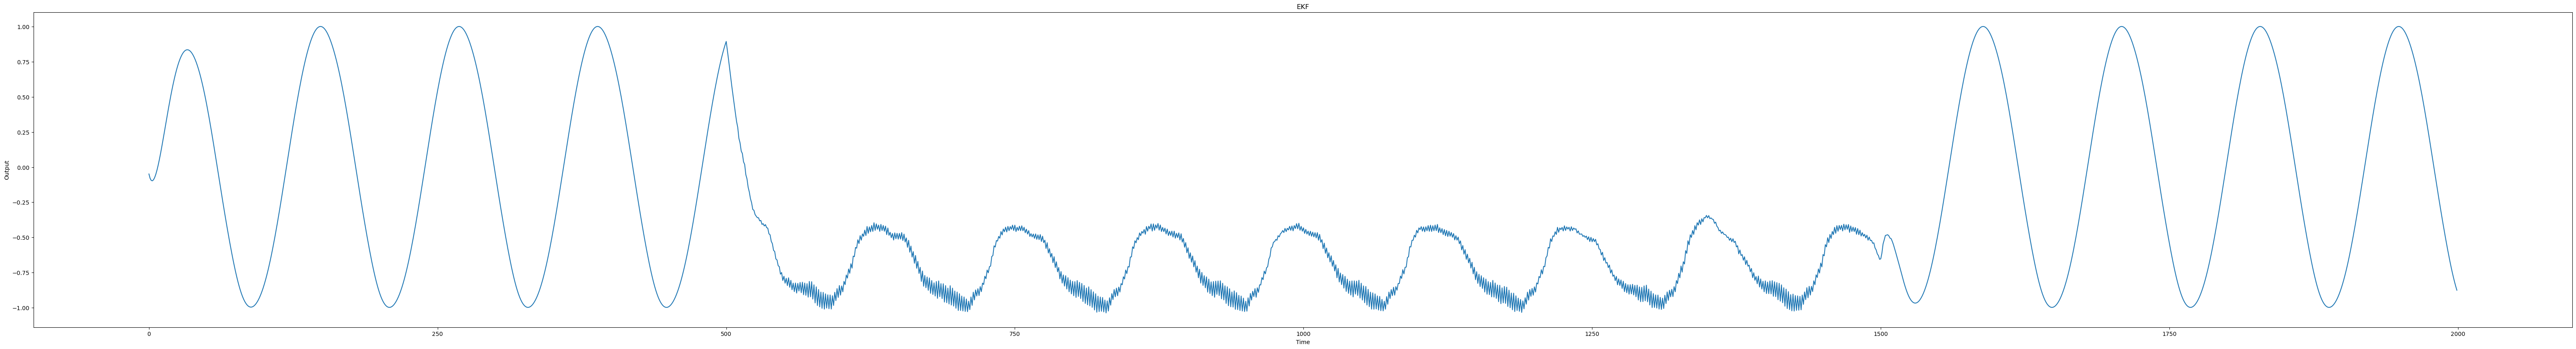

In [91]:
# Plot the state
plt.subplots(figsize=(80,10))
plt.plot(T, op_afterlqrs)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('EKF')
plt.show()

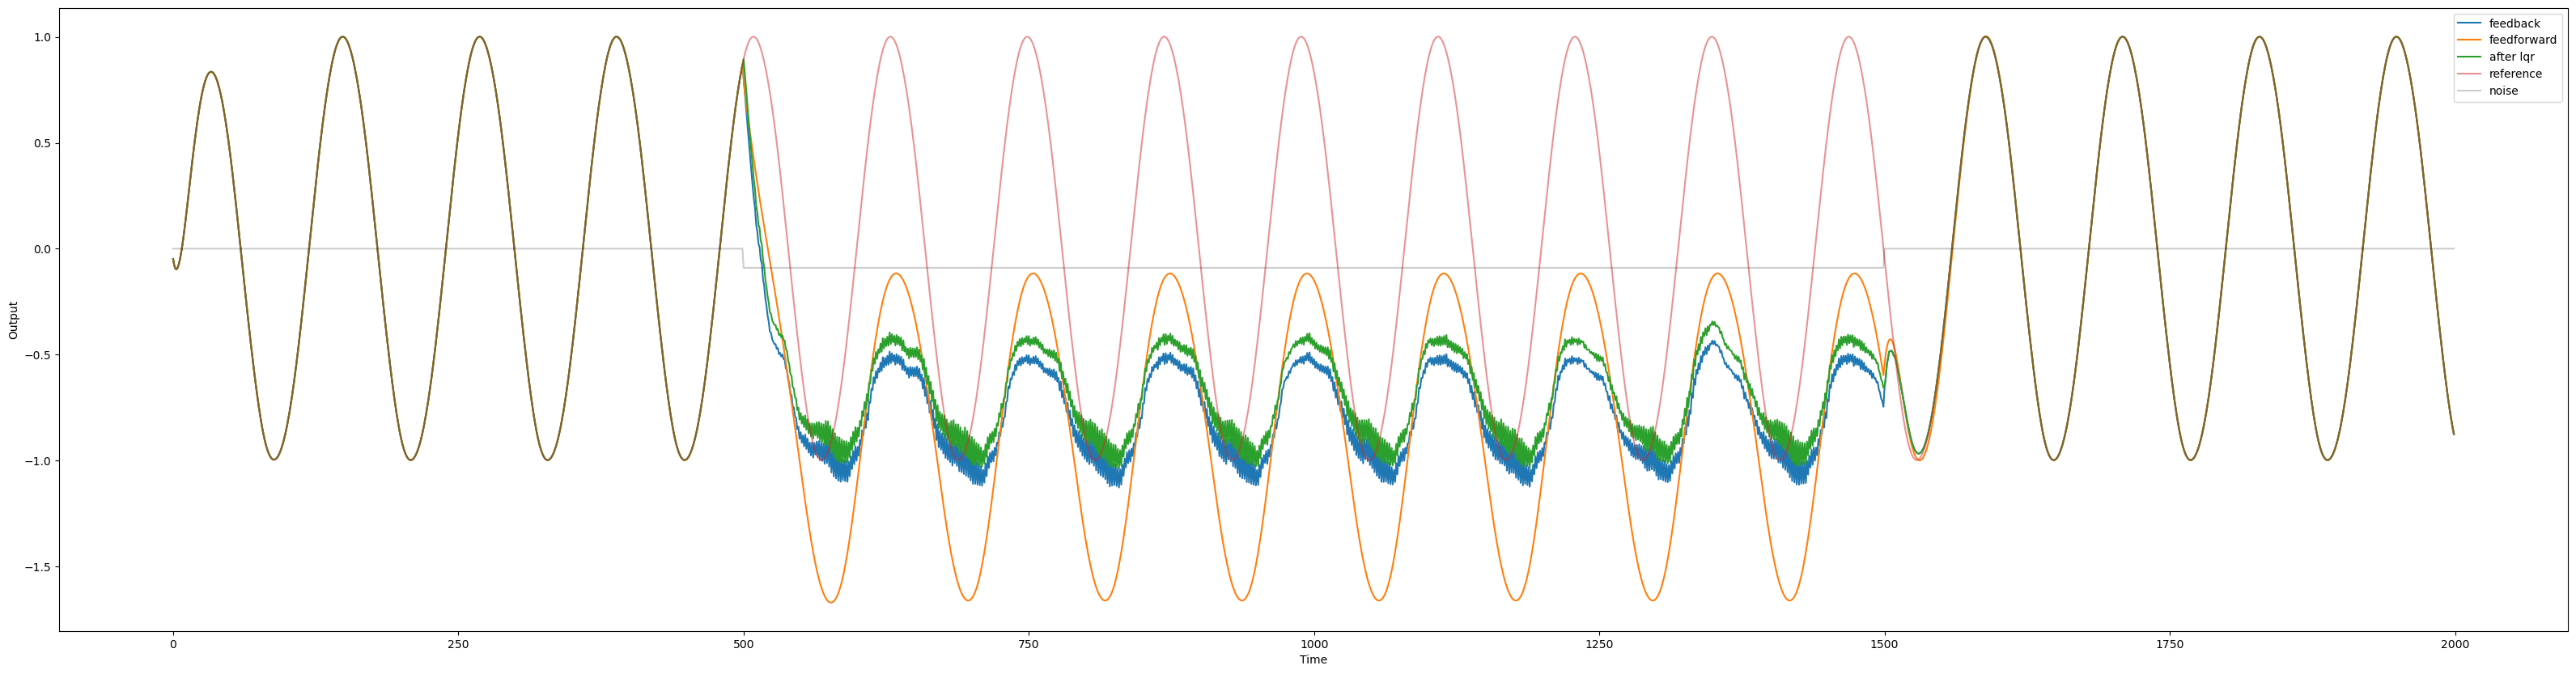

In [92]:
noises_out = (output_weight_matrix @ x_noises).squeeze()

# plt.subplots(figsize=(12,5))
plt.subplots(figsize=(40,10))
plt.plot(T, outputs_b, label='feedback')
plt.plot(T, outputs_o, label='feedforward')
plt.plot(T, op_afterlqrs, label='after lqr')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='reference')
plt.plot(T, noises_out, alpha=0.2, color='black', label='noise')
plt.xlabel('Time')
plt.ylabel('Output')
# plt.title('LQG')
plt.legend()
# plt.savefig("fig/sin_oja_lqg_learn.pdf")

Text(0, 0.5, 'MS of control signal')

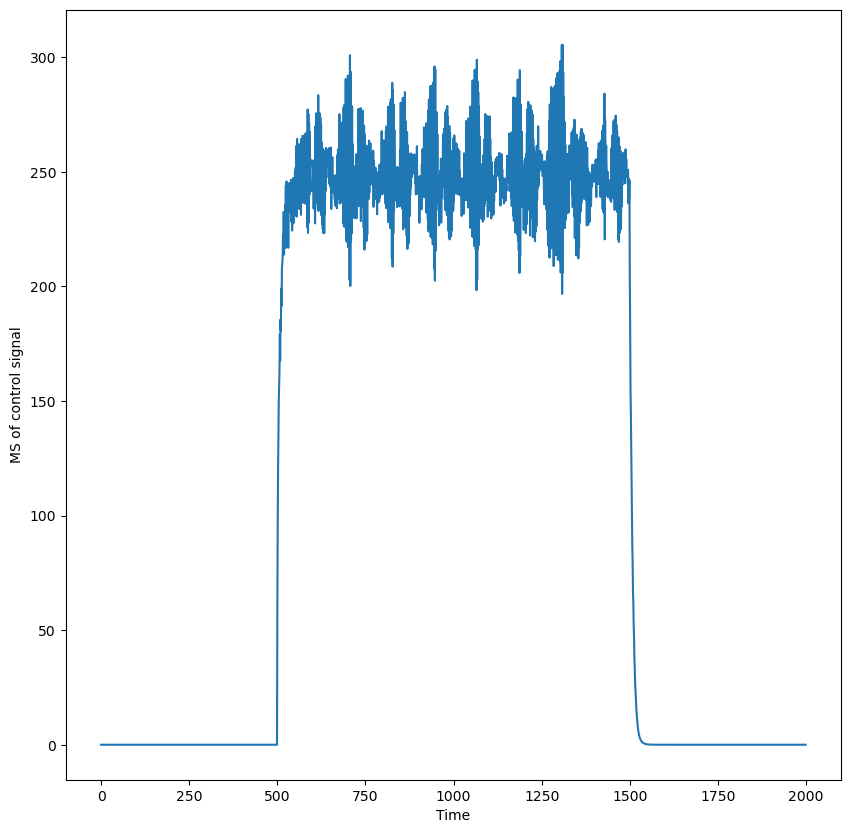

In [93]:
# plt.subplots(figsize=(12,5))
plt.subplots(figsize=(10,10))
# umeans = [np.mean(u**2).item() for u in ctrlus]
umeans = [np.sum(np.abs(u)) for u in ctrlus]
plt.plot(T, umeans)
# plt.ylim(0, 500)
plt.xlabel('Time')
plt.ylabel('MS of control signal')
# plt.savefig("fig/sin_oja_lqg_learn_umean.pdf")

## Non-linear LQG, ongoing hebbian learning

In [44]:
ideal_activations = activations.detach().numpy()
x = init_activations.copy()
u = init_activations.copy()
xhat = init_activations.copy()
Phat = W.copy()
xs = []
ys = []
ctrlus = []
xhats = []
outputs_b = []

oja_alpha = np.sqrt(num_nodes)
hebbian_lr = 0.001
hebb_alpha_ext = 611
hebb_alpha_inh = 618
weight_sums = []

for i in tqdm(T):

    jnn.i = i

    # Update x
    x_prenoise = jnn.f(x, u)
    process_noise = x_noises[:,i].reshape(-1,1)
    x = x_prenoise + Bnoise @ process_noise

    # Output
    measurement_noise = y_noises[:,i].reshape(-1,1)
    y = c @ x + measurement_noise
    output = output_weight_matrix @ x

    # Save
    xs.append(x)
    ys.append(y)
    outputs_b.append(output.item())

    # Kalman
    # xpred = jnn.f(xhat, u)
    # F, _ = jnn.jacob(xhat, u)
    # Ppred = F @ Phat @ F.T + W
    # ypred = c @ xpred

    # S = c @ Ppred @ c.T + V
    # Kf = Ppred @ c.T @ np.linalg.inv(S)

    # xhat = xpred + Kf @ (y - ypred)
    # phat = Ppred - Kf @ c @ Ppred
    # yres = y - c @ xhat

    xhat = x.copy()
    xhats.append(xhat)

    # LQR
    this_ideal_activation = ideal_activations[i,:].reshape(-1,1)
    A, B = jnn.jacob(x, u)
    X = sp_linalg.solve_discrete_are(A, B, Q, R)
    K = np.dot(np.linalg.pinv(R + np.dot(B.T, np.dot(X, B))), np.dot(B.T, np.dot(X, A)))
    u = -K @ (xhat - this_ideal_activation)
    ctrlus.append(u)
    # print(np.mean(u))

    # Oja's rule
    hebbian_update = x_prenoise @ x_prenoise.T
    hebbian_update = hebbian_update * (jnn.weight_type * 2 - 1) * jnn.connectivity_matrix
    jnn.weights = jnn.weights + hebbian_lr * hebbian_update
    tmp_weights_ext = jnn.weights[jnn.weight_type]
    tmp_weights_inh = jnn.weights[~jnn.weight_type]
    jnn.weights[jnn.weight_type] = tmp_weights_ext / np.sum(np.abs(tmp_weights_ext)) * hebb_alpha_ext
    jnn.weights[~jnn.weight_type] = tmp_weights_inh / np.sum(np.abs(tmp_weights_inh)) * hebb_alpha_inh    
    jnn.weights_tensor = tensor(jnn.weights)
    # print(np.mean(jnn.weights))
    weight_sums.append(np.sum(jnn.weights))

100%|██████████| 2000/2000 [07:34<00:00,  4.40it/s]


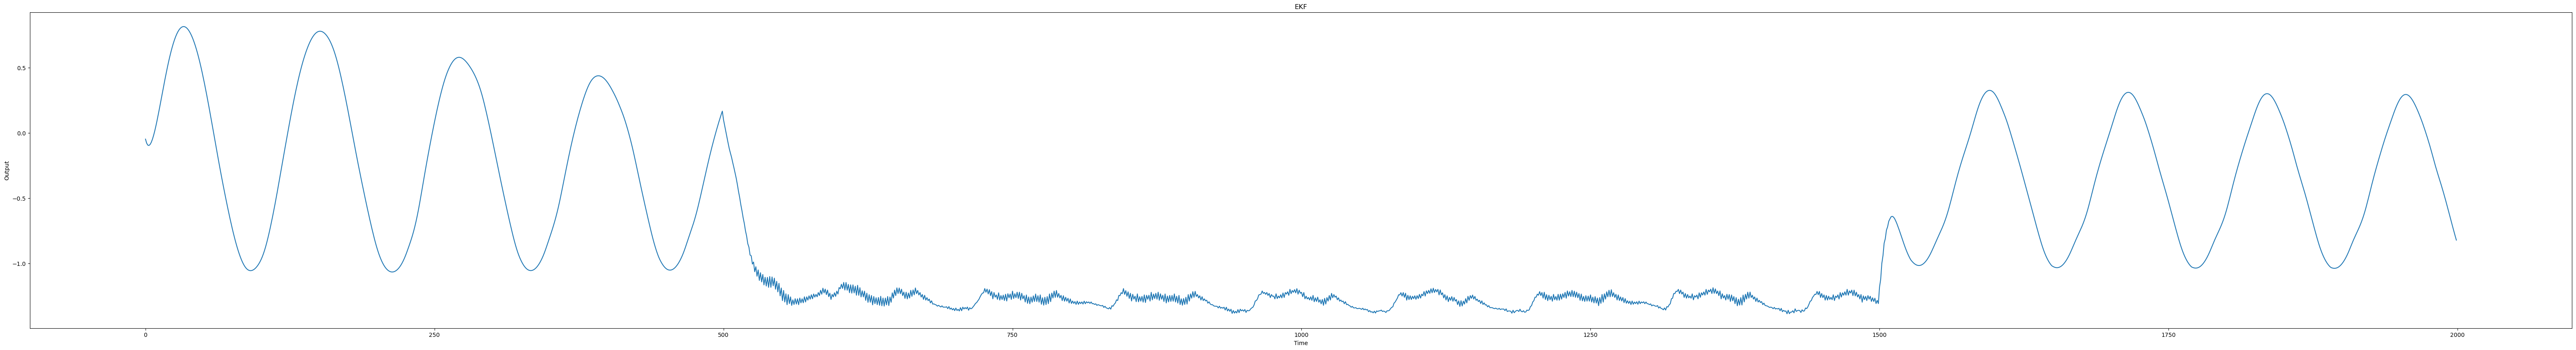

In [45]:
# Plot the state
plt.subplots(figsize=(80,10))
# outputhats = [(output_weight_matrix @ x).item() for x in xhats]
plt.plot(T, outputs_b)
# plt.plot(T, outputs_o)
# plt.plot(T, outputhats)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('EKF')
plt.show()

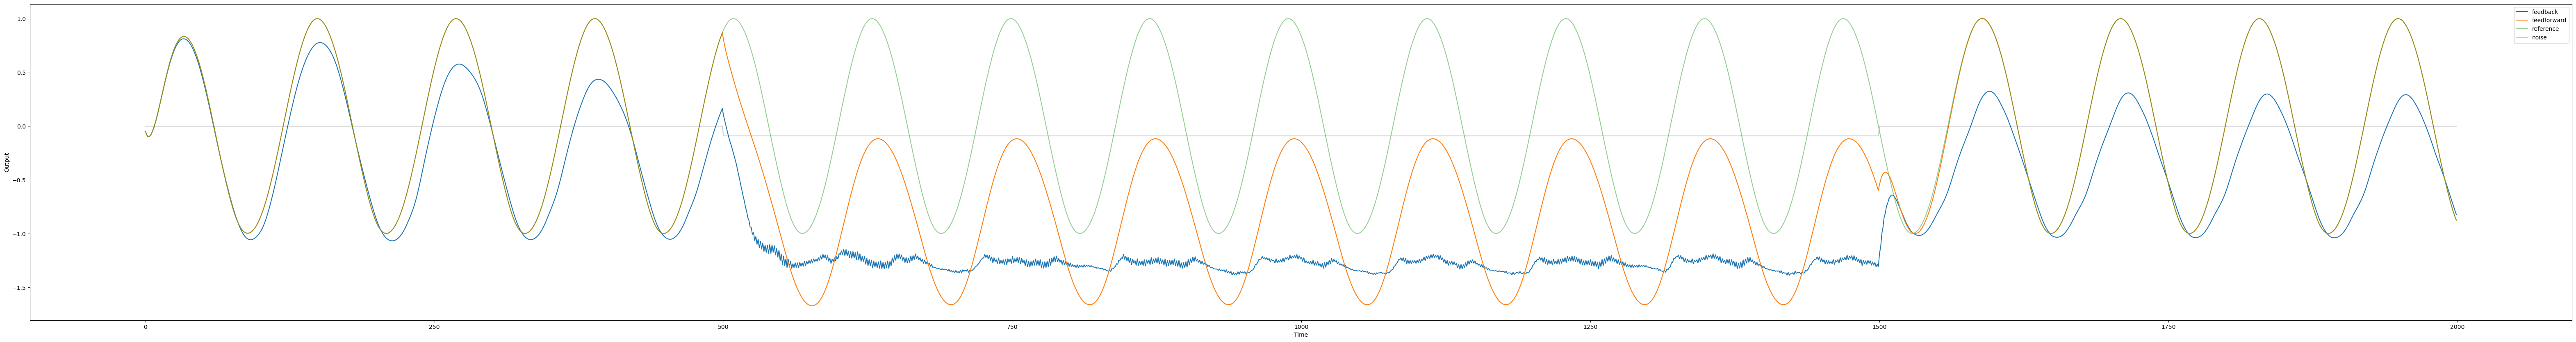

In [46]:
noises_out = (output_weight_matrix @ x_noises).squeeze()

# plt.subplots(figsize=(12,5))
plt.subplots(figsize=(80,10))
plt.plot(T, outputs_b, label='feedback')
plt.plot(T, outputs_o, label='feedforward')
plt.plot(time_points, outputs.detach().numpy(), alpha=0.5, label='reference')
plt.plot(T, noises_out, alpha=0.2, color='black', label='noise')
plt.xlabel('Time')
plt.ylabel('Output')
# plt.title('LQG')
plt.legend()
# plt.savefig("fig/sin_oja_lqg_learn.pdf")

Text(0, 0.5, 'MS of control signal')

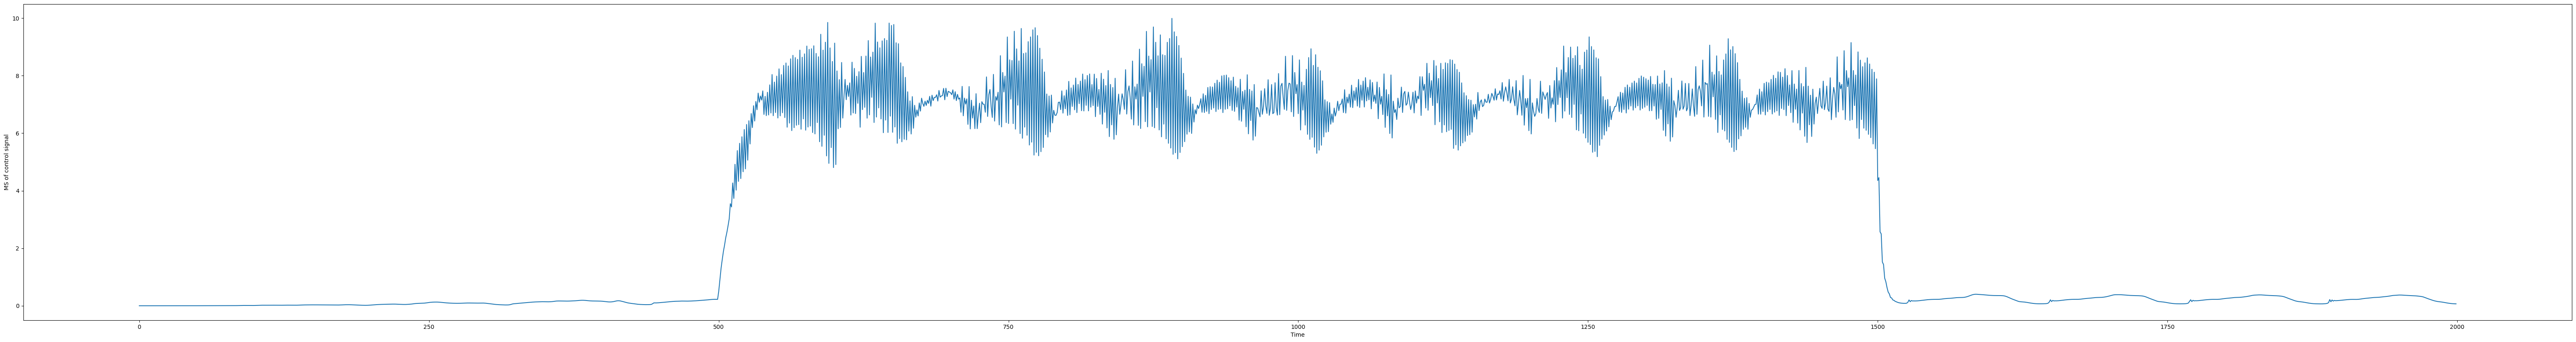

In [47]:
# plt.subplots(figsize=(12,5))
plt.subplots(figsize=(80,10))
umeans = [np.mean(u**2).item() for u in ctrlus]
plt.plot(T, umeans)
plt.xlabel('Time')
plt.ylabel('MS of control signal')
# plt.savefig("fig/sin_oja_lqg_learn_umean.pdf")

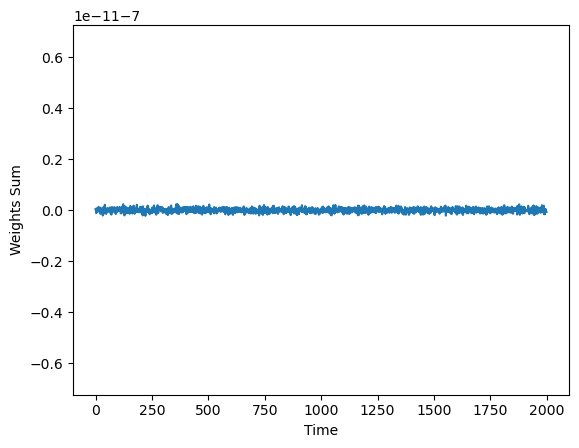

In [48]:
plt.xlabel("Time")
plt.ylabel("Weights Sum")
plt.plot(weight_sums)
# plt.savefig("fig/sin_oja_lqg_learn_weightsum.png")